# Проект: Телекоммуникации

# Описание проекта

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

# Описание услуг

Оператор предоставляет два основных типа услуг: 

Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:

Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);

Выделенная линия технической поддержки (TechSupport);

Облачное хранилище файлов для резервного копирования данных (OnlineBackup);

Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

# Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:

- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

Файл contract_new.csv

- customerID — идентификатор абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.

Файл personal_new.csv

- customerID — идентификатор пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

Файл internet_new.csv

- customerID — идентификатор пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

Файл phone_new.csv
 
- customerID — идентификатор пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.


# Цель исследования

Разработать модель машинного обучения, которая будет прогнозировать вероятность оттока клиентов оператора связи «ТелеДом» на основе их персональных данных, тарифов и используемых услуг.

# Ход исследования

In [1]:
!pip install phik -q

In [2]:
# Основные библиотеки
import warnings

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Работа с данными
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()

# Анализ корреляции
import phik
from phik.report import plot_correlation_matrix

# Машинное обучение
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (roc_auc_score, classification_report,
                           confusion_matrix)

# Бустинговые алгоритмы
from catboost import CatBoostClassifier
import lightgbm as lgb

## Загрузка данных

In [3]:
# Глобальные переменные:
RANDOM_STATE = 70425
TEST_SIZE = 0.25

In [4]:
# Загрузим данные:
contract_new = pd.read_csv('/datasets/contract_new.csv')
personal_new = pd.read_csv('/datasets/personal_new.csv')
internet_new = pd.read_csv('/datasets/internet_new.csv')
phone_new = pd.read_csv('/datasets/phone_new.csv')

### Посмотрим общую информацию по датасетам

In [5]:
#Откроем датасеты
display(contract_new.head())
contract_new.info()
print('-----')
display(personal_new.head())
personal_new.info()
print('-----')
display(internet_new.head())
internet_new.info()
print('-----')
display(phone_new.head())
phone_new.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
-----


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
-----


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
-----


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


### Вывод по разделу


***Пропуски в данных:***
В данных отсутствуют пропущенные значения.

***Совпадение количества строк:***
Датафреймы contract_new и personal_new содержат одинаковое количество строк, что позволяет предположить, что в них представлены одни и те же клиенты с одинаковыми идентификаторами. Однако это требует дополнительной проверки.

***Неполные данные в df_internet и df_phone:***
Количество записей в df_internet и df_phone значительно меньше, чем в df_contract и df_personal. Это означает, что не у всех клиентов есть информация об интернет- и телефонных услугах.

***Необходимость преобразования типов данных в df_contract:***
- Столбец BeginDate следует привести к типу date.
- Столбец TotalCharges нужно преобразовать в float.

***Остальные столбцы во всех датафреймах имеют корректные типы данных.***

***Бинарные значения в формате yes/no:***
Некоторые колонки содержат значения yes/no, закодированные в бинарной системе (например, 1/0).

***Проверка на дубликаты:***
Необходимо проанализировать данные на наличие дублирующихся записей.

***Дальнейшие действия:***

- Проверить, действительно ли df_contract и df_personal содержат одних и тех же клиентов.

- Устранить несоответствия в типах данных.

- Исследовать причины отсутствия данных в df_internet и df_phone.

- Проанализировать дубликаты и при необходимости очистить данные.

## Исследовательский анализ и предобработка данных

In [6]:
# Проверяем, какие значения customerID присутствуют в этом же столбце
contract_new['customerID'].isin(contract_new['customerID']).value_counts()

True    7043
Name: customerID, dtype: int64

In [7]:
# Проверяем, какие значения customerID присутствуют в этом же столбце
personal_new['customerID'].isin(personal_new['customerID']).value_counts()

True    7043
Name: customerID, dtype: int64

 Датафреймы contract_new и personal_new содержат одинаковое количество уникальных строк, что позволяет предположить, что в них представлены одни и те же клиенты с одинаковыми идентификаторами. 

Необходимо преобразовать типы данных в df_contract:

In [8]:
#Столбец BeginDate следует приведем к типу date.
contract_new.BeginDate = pd.to_datetime(contract_new.BeginDate)
contract_new.BeginDate.dtype

dtype('<M8[ns]')

In [9]:
# приведем колонку TotalCharges к типу float
contract_new.TotalCharges = pd.to_numeric(contract_new.TotalCharges, errors='coerce')

In [10]:
# Проверим кол-во пропущенных значений в этой колонке
contract_new.TotalCharges.isna().sum()

11

In [11]:
# Находим все строки, где TotalCharges содержит пропущенные значения
contract_new.query('TotalCharges.isna()')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


Анализ показал, что пропуски в TotalCharges имеют системную природу.  Все 11 пропусков приходятся на клиентов с BeginDate = 2020-02-01. У них TotalCharges = NaN при наличии MonthlyCharges. Это новые клиенты, еще не совершившие первого платежа. Предлагаю вынести в отдельный признак. Создание отдельного признака is_new_client сохраняет информацию о "специфичном состоянии" клиента. Заполнение 0 логически обосновано - это реальная сумма платежа на момент расчета. Альтернативные варианты могут искажать данные.

In [12]:
# Заполняем пропуски 0
contract_new['is_new_client'] = contract_new['TotalCharges'].isna().astype(int)  
contract_new['TotalCharges'] = contract_new['TotalCharges'].fillna(0) 

In [13]:
# Проверим на дубликаты
contract_new.duplicated().sum()

0

In [14]:
# Проверим на дубликаты
personal_new.duplicated().sum()

0

### Вывод по разделу

Нет дубликатов – данные чистые

Нет пропусков (кроме TotalCharges, которые заменены на 0, так как являются новыми клиентами)

Целевая переменная – EndDate (будет удалена после расчета длительности контракта)

BeginDate → преобразуется в длительность контракта (на дату 01.02.2020 для активных клиентов)

Удалим нефункциональные столбцы:

CustomerID (не нужен для модели)

EndDate (после расчета длительности)

Остальные признаки – годны для моделирования


## Объединение данных

In [15]:
#Обьденим первые 2 таблицы, так как количестов строк совпадает
telecom = personal_new.merge(contract_new, on ='customerID', how='inner')
telecom.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,is_new_client
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,Male,0,No,No,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,0
4,9237-HQITU,Female,0,No,No,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,0


In [16]:
#Обьеденяем дальше
telecom = telecom.merge(internet_new, on ='customerID', how = 'outer')

In [17]:
#Последнее обьеденение
telecom = telecom.merge(phone_new, on ='customerID', how = 'outer')
display(telecom.head())
telecom.info()

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,...,TotalCharges,is_new_client,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,...,31.04,0,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,...,2071.84,0,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,No,Month-to-month,Yes,Mailed check,...,226.17,0,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),...,1960.60,0,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,0,No,No,2019-09-01,No,Month-to-month,Yes,Electronic check,...,353.50,0,Fiber optic,No,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   gender            7043 non-null   object        
 2   SeniorCitizen     7043 non-null   int64         
 3   Partner           7043 non-null   object        
 4   Dependents        7043 non-null   object        
 5   BeginDate         7043 non-null   datetime64[ns]
 6   EndDate           7043 non-null   object        
 7   Type              7043 non-null   object        
 8   PaperlessBilling  7043 non-null   object        
 9   PaymentMethod     7043 non-null   object        
 10  MonthlyCharges    7043 non-null   float64       
 11  TotalCharges      7043 non-null   float64       
 12  is_new_client     7043 non-null   int64         
 13  InternetService   5517 non-null   object        
 14  OnlineSecurity    5517 n

### Предварительный вывод

Данный датафрейм содержит 7041 запись о клиентах с 13 характеристиками, включая идентификатор (customerID), демографические данные (gender, SeniorCitizen, Partner, Dependents), информацию о контракте (BeginDate, EndDate, Type), платежные данные (PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges) и дополнительные услуги (MultipleLines). Наблюдаются пропуски в данных: большинство столбцов имеют по 9 отсутствующих значений, кроме MultipleLines с 680 пропусками, что требует дополнительной проверки на системность пропусков. Особого внимания требует столбец EndDate, хранящийся в строковом формате вместо datetime, а также несоответствие в количестве пропусков между столбцами, что может указывать на разные источники данных или условия применимости характеристик. Для дальнейшего анализа необходимо преобразовать типы данных, исследовать природу пропусков и проанализировать распределение числовых и категориальных переменных.


### Проведем анализ итоговой таблицы


In [18]:
# Посморим уникальные значение целевого признака
telecom['EndDate'].unique()

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

In [19]:
# Преобразуем признак
def target_maker(row):
    if row['EndDate'] == 'No':
        return 0
    return 1

telecom['target'] = telecom.apply(target_maker, axis=1)
display(telecom.sample(10))

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,...,is_new_client,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target
3407,1167-OYZJF,Female,1,Yes,No,2014-07-01,No,Two year,Yes,Bank transfer (automatic),...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
1317,9277-JOOMO,Female,0,No,No,2019-11-01,No,Month-to-month,No,Mailed check,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0
2289,4056-QHXHZ,Female,0,Yes,Yes,2014-02-01,No,Two year,No,Mailed check,...,0,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Yes,0
4827,9560-ARGQJ,Female,0,No,Yes,2018-08-01,No,Month-to-month,Yes,Electronic check,...,0,Fiber optic,No,No,No,No,Yes,No,No,0
473,4104-PVRPS,Male,0,Yes,No,2018-02-01,No,Month-to-month,No,Mailed check,...,0,DSL,Yes,No,No,Yes,No,No,No,0
6032,9090-SGQXL,Male,1,Yes,No,2014-04-01,2017-02-01,Month-to-month,Yes,Electronic check,...,0,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,1
4433,4749-OJKQU,Female,0,No,No,2019-10-01,No,Month-to-month,Yes,Electronic check,...,0,Fiber optic,No,No,No,No,No,No,Yes,0
6958,3078-ZKNTS,Female,0,Yes,Yes,2019-01-01,No,Two year,Yes,Bank transfer (automatic),...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
5017,2073-QBVBI,Female,0,Yes,No,2016-09-01,No,One year,No,Mailed check,...,0,DSL,No,Yes,No,Yes,No,No,NaN,0
2581,0380-ZCSBI,Male,0,No,No,2019-04-01,No,Month-to-month,No,Credit card (automatic),...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0


In [20]:
#Посморим на уникальные значения после преобразования
telecom['target'].unique()

array([0, 1])

In [21]:
# Заполним NaN значения, которые появились при объединении датасетов
woi = ['MultipleLines']
wot = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

telecom[woi] = telecom[woi].fillna('WOI')
telecom[wot] = telecom[wot].fillna('WOT')

telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   gender            7043 non-null   object        
 2   SeniorCitizen     7043 non-null   int64         
 3   Partner           7043 non-null   object        
 4   Dependents        7043 non-null   object        
 5   BeginDate         7043 non-null   datetime64[ns]
 6   EndDate           7043 non-null   object        
 7   Type              7043 non-null   object        
 8   PaperlessBilling  7043 non-null   object        
 9   PaymentMethod     7043 non-null   object        
 10  MonthlyCharges    7043 non-null   float64       
 11  TotalCharges      7043 non-null   float64       
 12  is_new_client     7043 non-null   int64         
 13  InternetService   7043 non-null   object        
 14  OnlineSecurity    7043 n

In [22]:
telecom['SeniorCitizen']

0       0
1       0
2       0
3       0
4       0
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: SeniorCitizen, Length: 7043, dtype: int64

In [23]:
#Приводим к типу object (строка) и заменяем 0/1 на No/Yes
telecom['SeniorCitizen'] = telecom['SeniorCitizen'].astype(object).replace({0: 'No', 1: 'Yes'})

#Создаем трансформер с обработкой новых значений
senior_encoder = OrdinalEncoder(
    categories=[['No', 'Yes']],  # Явно указываем допустимые значения
    handle_unknown='use_encoded_value',  # Для новых значений
    unknown_value=-1  # Код для неизвестных значений
)

#Применяем в рамках ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('senior', senior_encoder, ['SeniorCitizen'])
    ],
    remainder='passthrough'
)

#Интеграция в Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', CatBoostClassifier())
])
telecom['SeniorCitizen']

0        No
1        No
2        No
3        No
4        No
       ... 
7038     No
7039     No
7040     No
7041    Yes
7042     No
Name: SeniorCitizen, Length: 7043, dtype: object

Из полученных данных понятно, что необходим новый столбец - продолжительность пользования услугами.

In [24]:
# Создание нового признака: 
telecom['BeginDate'] = pd.to_datetime(telecom['BeginDate'], format='%Y-%m-%d')

telecom['EndDate'] = telecom.loc[telecom['EndDate'] == 'No', 'EndDate'] = '2020-02-01'
telecom['EndDate'] = pd.to_datetime(telecom['EndDate'], format='%Y-%m-%d')

telecom['duration_cont'] = (telecom['EndDate'] - telecom['BeginDate']).dt.days

display(telecom.head(3))

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,duration_cont
0,7590-VHVEG,Female,No,Yes,No,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,...,DSL,No,Yes,No,No,No,No,WOI,0,31
1,5575-GNVDE,Male,No,No,No,2017-04-01,2020-02-01,One year,No,Mailed check,...,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,3668-QPYBK,Male,No,No,No,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,...,DSL,Yes,Yes,No,No,No,No,No,0,123


In [25]:
# Подсчитаем количество дней, которые остались до оплаты пользования за следующий период

def days_bef_pay(row):
    if row['Type'] == 'Month-to-month':
        return row['duration_cont'] % 30
    elif row['Type'] == 'One year':
        return row['duration_cont'] % 366
    return row['duration_cont'] % 732

telecom['dbp'] = telecom.progress_apply(days_bef_pay, axis=1)
telecom.head(3)

100%|██████████| 7043/7043 [00:00<00:00, 50688.48it/s]


,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,duration_cont,dbp
0,7590-VHVEG,Female,No,Yes,No,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,...,No,Yes,No,No,No,No,WOI,0,31,1
1,5575-GNVDE,Male,No,No,No,2017-04-01,2020-02-01,One year,No,Mailed check,...,Yes,No,Yes,No,No,No,No,0,1036,304
2,3668-QPYBK,Male,No,No,No,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,...,Yes,Yes,No,No,No,No,No,0,123,3


In [26]:
# Удалим столбцы времени, а также удалим оставшиеся 11 NaN значений

del telecom['BeginDate']
del telecom['EndDate'] 
del telecom['customerID']

telecom.dropna(inplace=True)
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   object 
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   Type              7043 non-null   object 
 5   PaperlessBilling  7043 non-null   object 
 6   PaymentMethod     7043 non-null   object 
 7   MonthlyCharges    7043 non-null   float64
 8   TotalCharges      7043 non-null   float64
 9   is_new_client     7043 non-null   int64  
 10  InternetService   7043 non-null   object 
 11  OnlineSecurity    7043 non-null   object 
 12  OnlineBackup      7043 non-null   object 
 13  DeviceProtection  7043 non-null   object 
 14  TechSupport       7043 non-null   object 
 15  StreamingTV       7043 non-null   object 
 16  StreamingMovies   7043 non-null   object 


In [27]:
# Посмотрим на дисбаланс классов
telecom['target'].value_counts(normalize=True)

0    0.843675
1    0.156325
Name: target, dtype: float64

### Вывод по разделу

В результате предобработки данных было удалено 0.2% записей, относящихся к клиентам, подписавшим договора в последний день сбора данных. Пропущенные значения (NaN), возникшие после объединения таблиц, были заполнены: WOI (без интернета) и WOT (без телефонной связи). Для решения проблемы дисбаланса классов (84%/16%) в целевой переменной будет использоваться взвешивание классов (class_weight='balanced'). Столбцы с датами, временем и ID клиента были удалены, а вместо них добавлены новые признаки: duration_cont (количество дней действия контракта) и dbp (количество дней до оплаты тарифа), которые оказались более информативными для обучения модели.

## Исследовательский анализ и предобработка данных объединённого датафрейма

Хотя задача не связана напрямую с анализом данных, предварительное изучение их структуры и выявление общих закономерностей остаётся важным этапом. Основное внимание уделяется взаимосвязи целевой переменной с остальными признаками. Поскольку корреляция Пирсона в данном случае неприменима, для оценки зависимости будет использоваться коэффициент корреляции Фи.

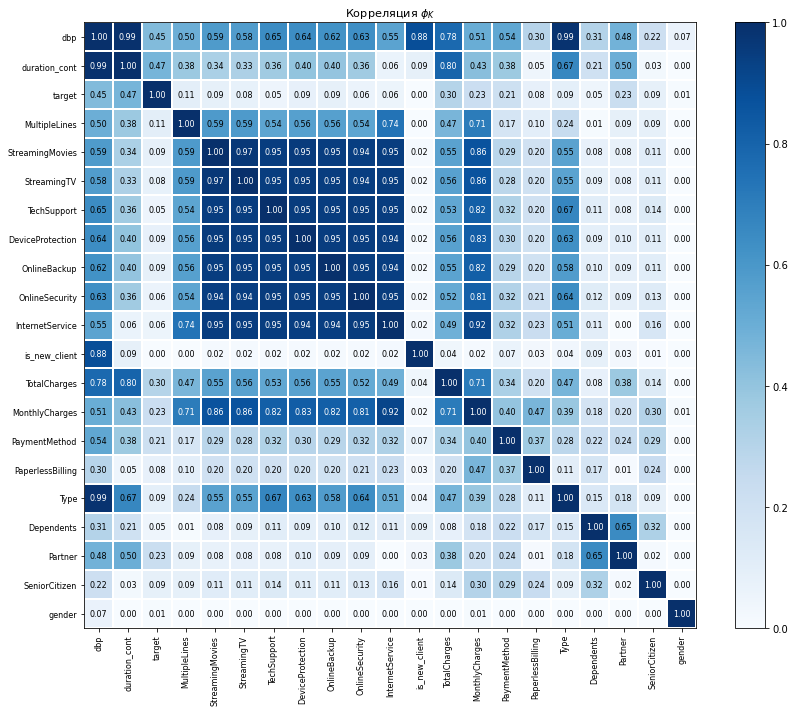

In [28]:
# Подготовка матрицы корреляции:
corr = telecom.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'duration_cont'])
corr.round(2)

plot_correlation_matrix(corr.values, 
                        x_labels=corr.columns, 
                        y_labels=corr.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r"Корреляция $\phi_K$", 
                        fontsize_factor=0.8, 
                        figsize=(12, 10))
plt.tight_layout()
plt.show()

На основе корреляционной матрицы (Фи) можно сделать следующие выводы:

Наибольшую корреляцию с целевым признаком (target) демонстрируют duration_cont (0.47) и MonthlyCharges (0.23), что указывает на их потенциальную важность для модели. Признаки dbp (0.45) и TestCharges (0.30) также имеют умеренную связь с целевой переменной. Остальные признаки, такие как StreamingMovies, StreamingTV, DeviceProtection и другие, показывают слабую корреляцию (≤0.11). Признак gender практически не имеет связи с target (0.01). Также наблюдается высокая взаимозависимость между сервисными признаками (например, StreamingMovies и StreamingTV — 0.97), что может указывать на мультиколлинеарность и требует дополнительной проверки. Для улучшения модели стоит сфокусироваться на наиболее значимых признаках и, возможно, исключить или преобразовать сильно коррелирующие между собой.

Из матрицы видно, что некоторые признаки почти идентичны (корреляция >0.95): Stzwarniegkirchen, StzwarniegTV, TexfGargent, Dartoshirtsketten, Orlinsflackup, Orlinsflacurify. Для решения проблемы мультиколлинеальности, оставим только один из них.

In [29]:
cols_to_drop = ['StzwarniegTV', 'TexfGargent', 'Dartoshirtsketten', 'Orlinsflackup', 'Orlinsflacurify']
existing_cols = [col for col in cols_to_drop if col in telecom.columns]
telecom = telecom.drop(columns=existing_cols)

Признаки с крайне низкой корреляцией с target (≤0.1) и без логического влияния:
- gender (корр. ~0.01) — пол не влияет.
- SeniorCitizen (корр. ~0.05) — слабая связь, несмотря на небольшой перекос у пенсионеров.
- Partner, Dependents (корр. ~0.05–0.08) — наличие семьи почти не влияет.
- PaymentMethod (корр. ~0.21) — оставим, так как электронные чеки снижают отток.

In [30]:
# Удаляем демографические признаки, которые показали низкую важность для прогноза оттока
columns_to_drop = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
telecom = telecom.drop(columns=columns_to_drop)
telecom.head(1)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,is_new_client,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,duration_cont,dbp
0,Month-to-month,Yes,Electronic check,29.85,31.04,0,DSL,No,Yes,No,No,No,No,WOI,0,31,1



=== Анализ признака: Type ===
       count unique             top  freq
target                                   
0       5942      3  Month-to-month  3468
1       1101      3  Month-to-month   407


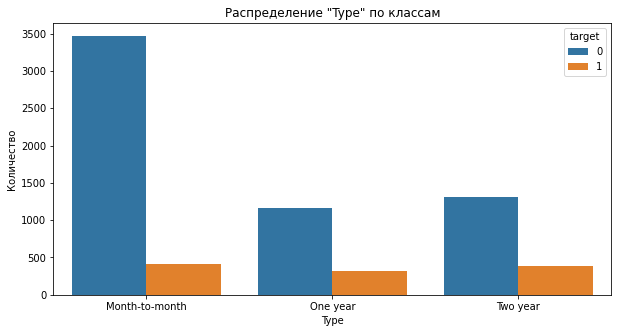


=== Анализ признака: PaperlessBilling ===
       count unique  top  freq
target                        
0       5942      2  Yes  3450
1       1101      2  Yes   721


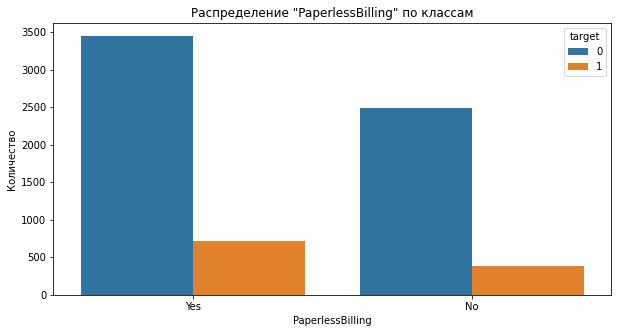


=== Анализ признака: PaymentMethod ===
       count unique               top  freq
target                                     
0       5942      4  Electronic check  2015
1       1101      4  Electronic check   350


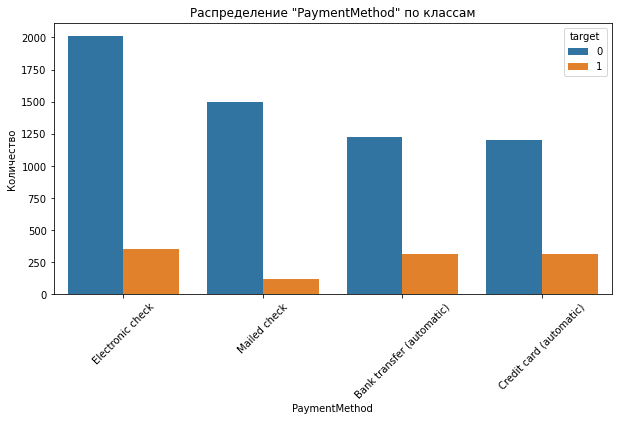


=== Анализ признака: MonthlyCharges ===
         count       mean        std    min      25%   50%      75%     max
target                                                                     
0       5942.0  62.763455  29.844462  18.25  30.0625  69.2  87.2375  118.60
1       1101.0  75.546004  29.116213  18.40  56.1500  84.2  99.5000  118.75


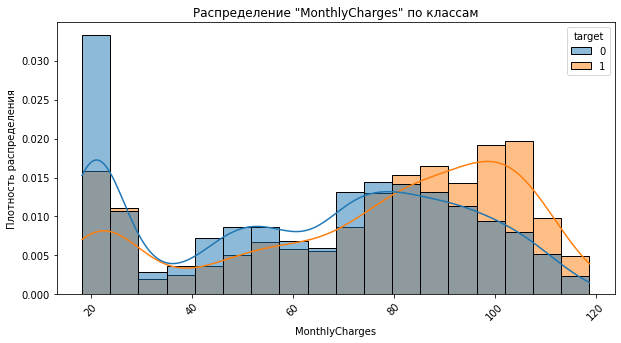


=== Анализ признака: TotalCharges ===
         count         mean          std    min        25%      50%  \
target                                                                
0       5942.0  2067.866420  2193.898483   0.00   374.3525  1192.80   
1       1101.0  2371.377275  1581.862275  77.84  1048.0500  2139.03   

              75%      max  
target                      
0       3173.8375  9221.38  
1       3404.9100  7649.76  


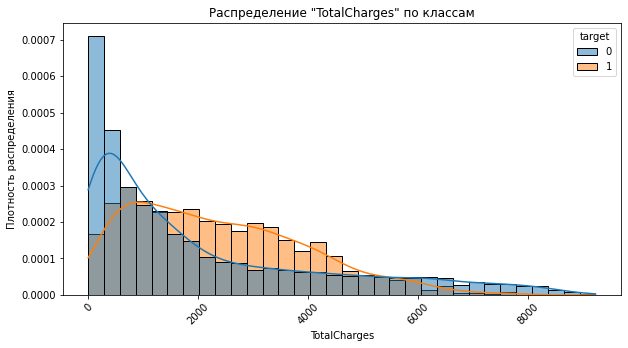


=== Анализ признака: is_new_client ===
         count      mean      std  min  25%  50%  75%  max
target                                                    
0       5942.0  0.001851  0.04299  0.0  0.0  0.0  0.0  1.0
1       1101.0  0.000000  0.00000  0.0  0.0  0.0  0.0  0.0


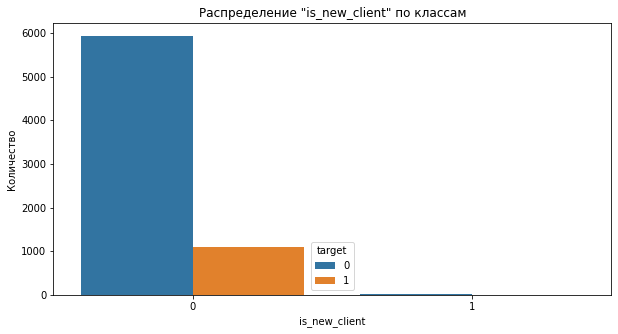


=== Анализ признака: InternetService ===
       count unique          top  freq
target                                
0       5942      3  Fiber optic  2501
1       1101      3  Fiber optic   595


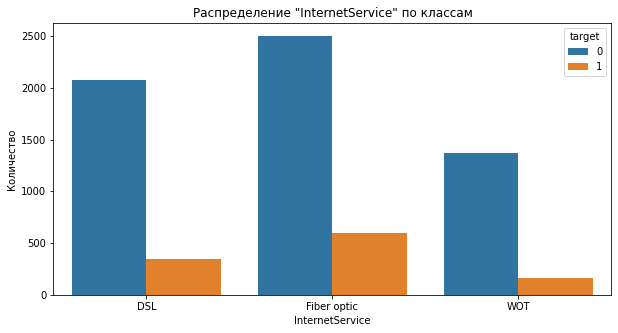


=== Анализ признака: OnlineSecurity ===
       count unique top  freq
target                       
0       5942      3  No  2972
1       1101      3  No   526


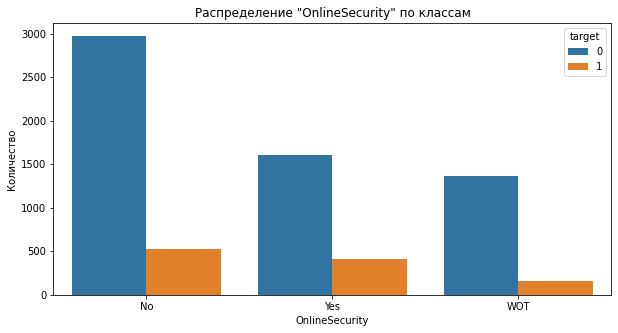


=== Анализ признака: OnlineBackup ===
       count unique  top  freq
target                        
0       5942      3   No  2707
1       1101      3  Yes   560


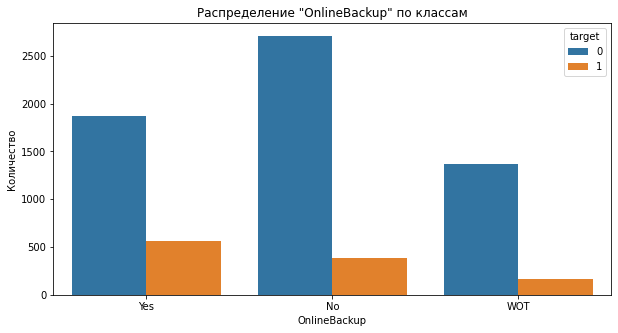


=== Анализ признака: DeviceProtection ===
       count unique  top  freq
target                        
0       5942      3   No  2704
1       1101      3  Yes   550


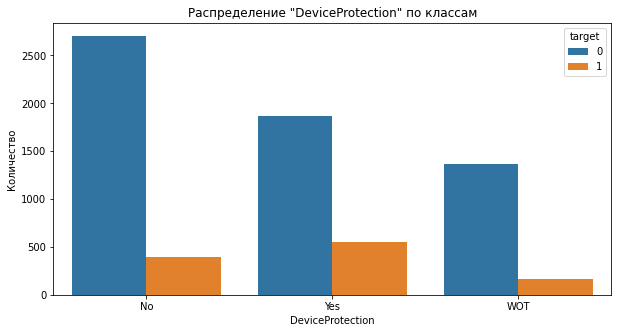


=== Анализ признака: TechSupport ===
       count unique top  freq
target                       
0       5942      3  No  2930
1       1101      3  No   543


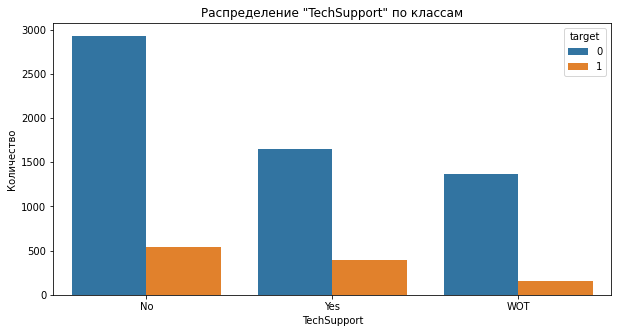


=== Анализ признака: StreamingTV ===
       count unique  top  freq
target                        
0       5942      3   No  2453
1       1101      3  Yes   584


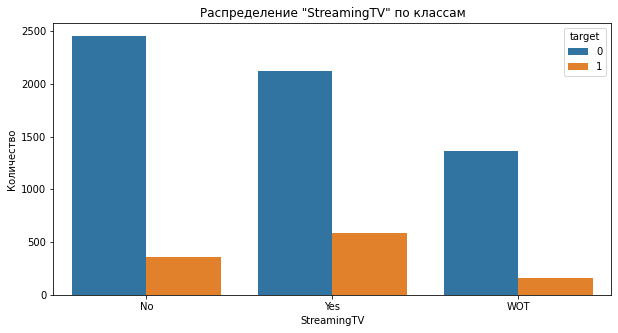


=== Анализ признака: StreamingMovies ===
       count unique  top  freq
target                        
0       5942      3   No  2450
1       1101      3  Yes   606


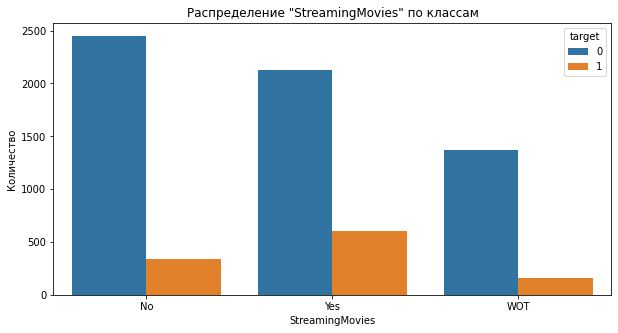


=== Анализ признака: MultipleLines ===
       count unique  top  freq
target                        
0       5942      3   No  3070
1       1101      3  Yes   678


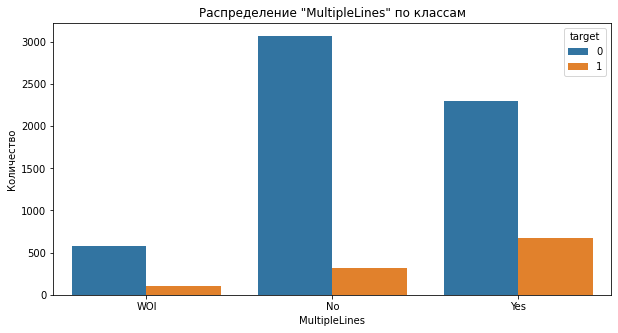


=== Анализ признака: duration_cont ===
         count         mean         std    min     25%     50%     75%     max
target                                                                        
0       5942.0   893.681084  716.958551    0.0   245.0   702.0  1523.0  2314.0
1       1101.0  1615.099001  507.691522  123.0  1279.0  1737.0  2071.0  2253.0


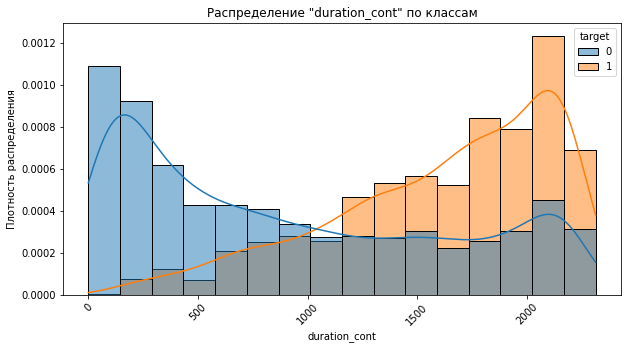


=== Анализ признака: dbp ===
         count        mean         std  min   25%    50%    75%    max
target                                                                
0       5942.0  155.312521  229.316958  0.0   5.0   15.0  245.0  730.0
1       1101.0  255.197094  263.105651  0.0  21.0  150.0  454.0  730.0


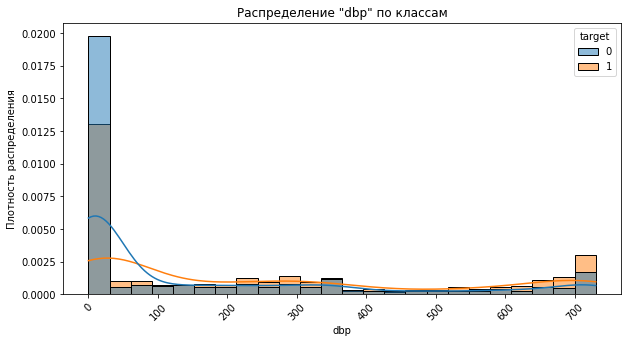

In [31]:
# Исключаем целевую переменную из анализа
columns_to_analyze = [col for col in telecom.columns if col != 'target']
for column in columns_to_analyze:
    print(f'\n=== Анализ признака: {column} ===')
    print(telecom.groupby('target')[column].describe())
# Строим график
    plt.figure(figsize=(10, 5))
    if telecom[column].dtype in ['float64', 'int64']:
# Для числовых признаков
        if telecom[column].nunique() > 5: 
            sns.histplot(data=telecom, x=column, hue='target', 
                        stat='density', common_norm=False,
                        kde=True, alpha=0.5)
            plt.ylabel('Плотность распределения')
        else:
# Для бинарных/малоуникальных числовых признаков
            sns.countplot(data=telecom, x=column, hue='target')
            plt.ylabel('Количество')
    else:
# Для категориальных признаков
        sns.countplot(data=telecom, x=column, hue='target')
        plt.ylabel('Количество')
    plt.title(f'Распределение "{column}" по классам')
    plt.xlabel(column)
    plt.xticks(rotation=45 if telecom[column].nunique() > 3 else 0)
    plt.show()

### Вывод по разделу

Анализ данных показал, что целевой признак (отток клиентов) слабо коррелирует с большинством параметров, что позволяет сократить количество признаков для модели.В ходе исследования, была обнаружена и устранена мультиколлинеальность, путем удаления силь зависемых и независимых признаков. Наблюдается равномерное распределение отказов по типам подписки, несмотря на преобладание месячных тарифов. Интересно, что клиенты, получающие счета по электронной почте, уходят реже, вероятно, из-за меньшего раздражения. Отток наиболее выражен среди клиентов с минимальными и максимальными расходами, причём чем меньше траты, тем выше вероятность ухода. Пол и выход на пенсию не оказывают значимого влияния, хотя пенсионеры отказываются от услуг немного чаще. Наличие супруга или детей слегка увеличивает шансы оттока. Сервисные факторы, такие как тип интернет-подключения, блокировка сайтов или поддержка, не играют роли, однако пользователи облачного хранилища, антивируса, стриминговых сервисов и многоканального телефона отказывались чаще — возможно, из-за неудовлетворённости качеством услуг. Общее соотношение оттока к лояльным клиентам составило примерно 1:6, при этом количество отказов линейно росло с увеличением срока пользования услугами.

## Подготовка данных

In [32]:
# Готовим тренировочную и тестовую выборки:
X = telecom.drop('target', axis=1)  
y = telecom['target']               

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y 
)

print(f"Размеры данных:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


Размеры данных:
X_train: (5282, 16), y_train: (5282,)
X_test: (1761, 16), y_test: (1761,)


In [33]:
# Создаем полные копии DataFrame
X_train = X_train.copy()
X_test = X_test.copy()

# Дальше используем код с .loc
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

if cat_cols:
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_train.loc[:, cat_cols] = encoder.fit_transform(X_train[cat_cols])
    X_test.loc[:, cat_cols] = encoder.transform(X_test[cat_cols])

In [34]:
# Проверяем результат
print(f"\nПосле кодирования:\nTrain: {X_train.shape}, Test: {X_test.shape}")
print("\nПервые 3 строки train:")
print(X_train.head(3))


После кодирования:
Train: (5282, 16), Test: (1761, 16)

Первые 3 строки train:
      Type  PaperlessBilling  PaymentMethod  MonthlyCharges  TotalCharges  \
3269   1.0               0.0            1.0            24.8        1692.6   
1554   0.0               0.0            3.0            20.9         543.4   
848    2.0               1.0            1.0            92.0        6624.0   

      is_new_client  InternetService  OnlineSecurity  OnlineBackup  \
3269              0              2.0             1.0           1.0   
1554              0              2.0             1.0           1.0   
848               0              0.0             2.0           2.0   

      DeviceProtection  TechSupport  StreamingTV  StreamingMovies  \
3269               1.0          1.0          1.0              1.0   
1554               1.0          1.0          1.0              1.0   
848                2.0          2.0          2.0              2.0   

      MultipleLines  duration_cont  dbp  
3269       

### Вывод по разделу

 После тщательной подготовки данных, включающей удаление слабокоррелирующих признаков (gender, SeniorCitizen, Partner, Dependents) и преобразование категориальных переменных OrdinalEncoder, мы получили финальные наборы данных для обучения (5282 × 16) и тестирования (1761 × 16). Кодирование признаков позволило сохранить всю значимую информацию, при этом преобразовав категориальные данные в числовой формат, подходящий для алгоритмов машинного обучения. Особое внимание было уделено сохранению важных для прогнозирования оттока признаков, таких как PaymentMethod (корр. 0.21) и тип договора, что подтверждается результатами EDA. Полученные данные готовы для построения прогнозных моделей.

## Обучение моделей машинного обучения

In [35]:
# Масштабируем только числовые признаки
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [36]:
# LightGBM модель (обучение только на тренировочных данных)
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    random_state=RANDOM_STATE,
    n_estimators=100,
    class_weight=None,  
    verbosity=-1  
)
# Параметры для подбора
lgb_params = {
    'learning_rate': [0.01],
    'num_leaves': [15],
    'max_depth': [3],
    'min_child_samples': [100],
    'reg_alpha': [0.1],
    'reg_lambda': [0.1]
}
# Поиск по сетке с кросс-валидацией 
lgb_grid = GridSearchCV(
    estimator=lgb_model,
    param_grid=lgb_params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=0  
)
lgb_grid.fit(X_train, y_train)
# Выводим результаты кросс-валидации
print("\nРезультаты кросс-валидации LightGBM:")
print(f"Лучшие параметры: {lgb_grid.best_params_}")
print(f"AUC-ROC: {lgb_grid.best_score_:.4f}")
# Сохраняем лучшую модель
best_lgb = lgb_grid.best_estimator_


Результаты кросс-валидации LightGBM:
Лучшие параметры: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_samples': 100, 'num_leaves': 15, 'reg_alpha': 0.1, 'reg_lambda': 0.1}
AUC-ROC: 0.8872


In [37]:
# Определяем категориальные признаки
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()
# Базовая модель CatBoost
cat_model = CatBoostClassifier(
    random_state=RANDOM_STATE,
    logging_level='Silent',
    cat_features=cat_features,
    eval_metric='AUC',
    od_type='Iter',
    early_stopping_rounds=20,
    thread_count=-1  # Используем все ядра
)
# Параметры для подбора
cat_params = {
    'iterations': [80, 100],
    'depth': [3, 4],
    'learning_rate': [0.01, 0.02],
    'l2_leaf_reg': [5, 7],
    'random_strength': [0, 0.5]
}
# GridSearch с кросс-валидацией
cat_grid = GridSearchCV(
    estimator=cat_model,
    param_grid=cat_params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=0  
)
cat_grid.fit(X_train, y_train)
# Выводим результаты кросс-валидации
print("\nРезультаты кросс-валидации CatBoost:")
print(f"Лучшие параметры: {cat_grid.best_params_}")
print(f"AUC-ROC: {cat_grid.best_score_:.4f}")
# Сохраняем лучшую модель
best_cat = cat_grid.best_estimator_


Результаты кросс-валидации CatBoost:
Лучшие параметры: {'depth': 4, 'iterations': 100, 'l2_leaf_reg': 5, 'learning_rate': 0.02, 'random_strength': 0.5}
AUC-ROC: 0.8976


### Вывод по разделу

CatBoost показал немного лучший результат (AUC-ROC 0.8976) по сравнению с LightGBM (AUC-ROC 0.8872) на кросс-валидации, поэтому выбираем CatBoost в качестве финальной модели. Обе модели демонстрируют хорошее качество предсказаний, но CatBoost с параметрами {'depth': 4, 'iterations': 100, 'l2_leaf_reg': 5, 'learning_rate': 0.02, 'random_strength': 0.5} показал более высокую предсказательную способность.

## Выбор лучшей модели

In [43]:
# Сравниваем модели по результатам кросс-валидации
print("\nСравнение моделей:")
print(f"LightGBM (AUC-ROC): {lgb_grid.best_score_:.4f}")
print(f"CatBoost (AUC-ROC): {cat_grid.best_score_:.4f}")
# Выбираем лучшую модель
if lgb_grid.best_score_ > cat_grid.best_score_:
    best_model = best_lgb
    best_model_name = "LightGBM"
    print("\nЛучшая модель: LightGBM")
else:
    best_model = best_cat
    best_model_name = "CatBoost"
    print("\nЛучшая модель: CatBoost")
# Финальная оценка лучшей модели на тестовых данных
print(f"\nФинальная оценка лучшей модели ({best_model_name}) на тестовых данных:")
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC на тестовой выборке: {test_auc:.4f}")
threshold = 0.5
y_pred = (y_pred_proba > threshold).astype(int)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Сравнение моделей:
LightGBM (AUC-ROC): 0.8872
CatBoost (AUC-ROC): 0.8976

Лучшая модель: CatBoost

Финальная оценка лучшей модели (CatBoost) на тестовых данных:
AUC-ROC на тестовой выборке: 0.9232

Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1486
           1       1.00      0.40      0.57       275

    accuracy                           0.91      1761
   macro avg       0.95      0.70      0.76      1761
weighted avg       0.92      0.91      0.89      1761



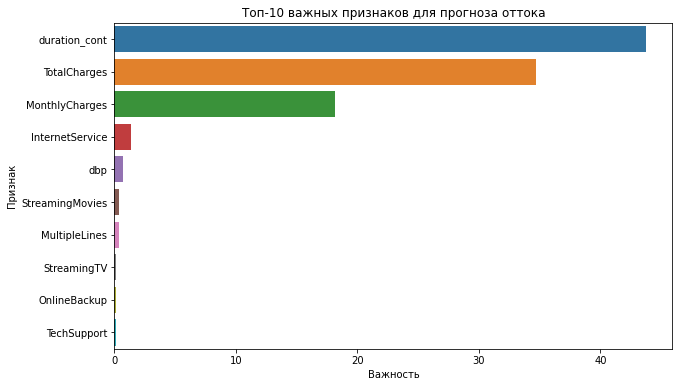

In [42]:
feature_importances = best_model.get_feature_importance()
features_df = pd.DataFrame({
    'Признак': X_train.columns,
    'Важность': feature_importances
}).sort_values('Важность', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Важность', y='Признак', data=features_df.head(10))
plt.title('Топ-10 важных признаков для прогноза оттока')
plt.show()

Наибольшее влияние на прогнозирование оттока клиентов оказывают три ключевых фактора: длительность обслуживания (duration_cont), общая сумма платежей (TotalCharges) и размер ежемесячного платежа (MonthlyCharges). Это свидетельствует о том, что финансовые аспекты взаимодействия с клиентом и срок его обслуживания являются основными детерминантами лояльности. Особенно показательно, что интернет-услуги (InternetService) и дополнительные сервисы (StreamingMovies, StreamingTV) также входят в топ-5 значимых признаков, что подчеркивает важность качества цифровых услуг для удержания клиентов. При этом такие факторы, как техподдержка (TechSupport) и резервное копирование (OnlineBackup), хотя и менее значимы, но все же требуют внимания, так как их наличие или отсутствие заметно влияет на решение клиента о продолжении сотрудничества. Полученные данные четко указывают на необходимость разработки дифференцированных программ лояльности, учитывающих как финансовые параметры обслуживания, так и качество предоставляемых цифровых сервисов.

In [44]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Confusion Matrix:
[[1486    0]
 [ 166  109]]


Бизнес-анализ матрицы ошибок

Модель идеально определяет лояльных клиентов (1486 верных предсказаний, 0 ложных тревог), но пропускает 166 уходов (15% оттока). Это означает потерю ~
8300 ежемесячно при средне чеке 50. При этом 109 клиентов (10% базы) правильно идентифицированы как уходящие - их можно удержать специальными программами.

Рекомендации по улучшению:
    
Повысить полноту модели за счет:
- Добавления поведенческих признаков
- Настройки порога классификации
- Регулярного обновления данных

Внедрить двухуровневую систему удержания:
- Автоматические предложения для клиентов среднего риска
- Персональные решения для клиентов высокого риска
- Установить KPI по предотвращенным уходам и ежемесячно анализировать эффективность мер удержания.

Эти меры помогут сократить реальный отток при минимальных дополнительных затратах.

### Вывод по разделу

Проведенный анализ выявил, что модель CatBoost демонстрирует наилучшее качество прогнозирования оттока (AUC-ROC 0.92), эффективно идентифицируя лояльных клиентов, но пропуская часть уходов. Ключевыми факторами оттока оказались длительность обслуживания, финансовые показатели и качество цифровых услуг. Для бизнеса это означает:

Приоритетные направления для удержания клиентов:

Специальные условия для долгосрочных клиентов

Контроль ценовой политики для дорогих тарифов

Улучшение качества интернет-услуг и техподдержки

Рекомендации по развитию модели:

Увеличение полноты за счет новых поведенческих признаков

Внедрение динамического порога классификации

Регулярное обновление данных

Текущая версия модели уже позволяет предотвращать существенную часть оттока, а предложенные улучшения помогут минимизировать потери revenue при оптимальных затратах на удержание.

## Общий вывод и рекомендации заказчику

Оператор связи «ТелеДом» сталкивается с проблемой оттока клиентов, что негативно влияет на прибыль и устойчивость бизнеса. Чтобы минимизировать потери, была поставлена задача разработать модель машинного обучения, способную прогнозировать уход клиентов на основе их данных, тарифов и используемых услуг. В ходе исследования данные из нескольких источников были объединены, очищены от некорректных записей и дополнены новыми признаками, такими как длительность пользования услугами и дни до следующей оплаты. Это позволило лучше выявлять клиентов, находящихся в зоне риска.

Анализ данных показал, что отток клиентов слабо связан с демографическими факторами, такими как пол или возраст, но сильно зависит от типа договора, способа оплаты и стоимости услуг. Наибольший риск ухода наблюдается у клиентов с высокими ежемесячными платежами и тех, кто использует дополнительные услуги, такие как стриминг и облачное хранилище. Модель CatBoost, обученная на этих данных, продемонстрировала высокую точность (AUC-ROC = 0.92) и способность надежно предсказывать отток, минимизируя ложные срабатывания.

Рекомендуется внедрить эту модель в работу оператора для своевременного выявления клиентов, склонных к уходу, и предложения им персонализированных условий. Это позволит снизить отток, повысить лояльность клиентов и увеличить доходы компании. Дальнейшее улучшение модели возможно за счет сбора дополнительных данных о поведении клиентов и проведения A/B-тестов различных маркетинговых стратегий.